<a href="https://colab.research.google.com/github/kaushalshah178/Deep-Learning-assignment/blob/main/DL_assignment1_kaushal_shah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils 

In [ ]:
import keras

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/dataset/houseprice.xlsx")
df.sample(5)

,area,bedrooms,price
3,1521,3,75.0
7,3300,4,155.0
10,1800,3,82.0
9,3700,5,167.0
8,1310,3,50.0


In [ ]:
from sklearn import preprocessing
sx = preprocessing.MinMaxScaler()
sy = preprocessing.MinMaxScaler()

scaled_X = sx.fit_transform(df.drop('price',axis='columns'))
scaled_y = sy.fit_transform(df['price'].values.reshape(df.shape[0],1))

scaled_X

array([[0.08827586, 0.25      ],
       [0.62068966, 0.75      ],
       [0.22068966, 0.5       ],
       [0.24862069, 0.5       ],
       [0.13793103, 0.25      ],
       [0.12758621, 0.25      ],
       [0.6662069 , 0.75      ],
       [0.86206897, 0.75      ],
       [0.17586207, 0.5       ],
       [1.        , 1.        ],
       [0.34482759, 0.5       ],
       [0.68448276, 0.75      ],
       [0.06896552, 0.25      ],
       [0.10344828, 0.25      ],
       [0.5       , 0.5       ],
       [0.12931034, 0.25      ],
       [0.13103448, 0.5       ],
       [0.25517241, 0.5       ],
       [0.67931034, 0.5       ],
       [0.        , 0.        ]])

In [ ]:
scaled_y

array([[0.05237037],
       [0.65185185],
       [0.22222222],
       [0.31851852],
       [0.14074074],
       [0.04444444],
       [0.76296296],
       [0.91111111],
       [0.13333333],
       [1.        ],
       [0.37037037],
       [0.8       ],
       [0.04444444],
       [0.05925926],
       [0.51111111],
       [0.07407407],
       [0.11851852],
       [0.20740741],
       [0.51851852],
       [0.        ]])

In [ ]:
scaled_y.reshape(20,)

array([0.05237037, 0.65185185, 0.22222222, 0.31851852, 0.14074074,
       0.04444444, 0.76296296, 0.91111111, 0.13333333, 1.        ,
       0.37037037, 0.8       , 0.04444444, 0.05925926, 0.51111111,
       0.07407407, 0.11851852, 0.20740741, 0.51851852, 0.        ])

In [ ]:
def batch_gradient_descent(X, y_true, epochs, learning_rate = 0.01):

    number_of_features = X.shape[1]
    # numpy array with 1 row and columns equal to number of features. In 
    # our case number_of_features = 2 (area, bedroom)
    w = np.ones(shape=(number_of_features)) 
    b = 0
    total_samples = X.shape[0] # number of rows in X
    
    cost_list = []
    epoch_list = []
    
    for i in range(epochs):        
        y_predicted = np.dot(w, X.T) + b

        w_grad = -(2/total_samples)*(X.T.dot(y_true-y_predicted))
        b_grad = -(2/total_samples)*np.sum(y_true-y_predicted)
        
        w = w - learning_rate * w_grad
        b = b - learning_rate * b_grad
        
        cost = np.mean(np.square(y_true-y_predicted)) # MSE (Mean Squared Error)
        
        if i%10==0:
            cost_list.append(cost)
            epoch_list.append(i)
        
    return w, b, cost, cost_list, epoch_list

w, b, cost, cost_list, epoch_list = batch_gradient_descent(scaled_X,scaled_y.reshape(scaled_y.shape[0],),500)
w, b, cost

(array([0.70712464, 0.67456527]), -0.23034857438407427, 0.0068641890429808105)

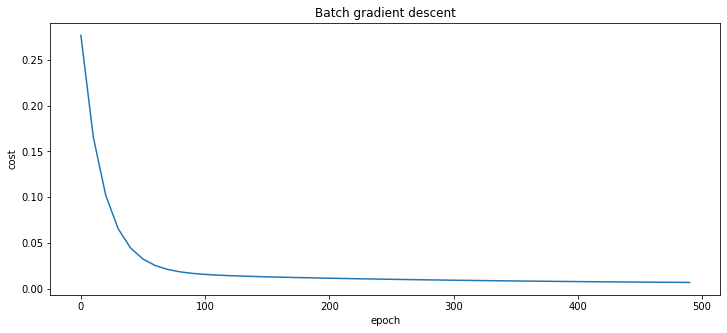

In [ ]:
plt.figure(figsize=(12, 5))
plt.title("Batch gradient descent")
plt.xlabel("epoch")
plt.ylabel("cost")
plt.plot(epoch_list,cost_list)


In [ ]:
def predict(area,bedrooms,w,b):
    scaled_X = sx.transform([[area, bedrooms]])[0]
    # here w1 = w[0] , w2 = w[1], w3 = w[2] and bias is b
    # equation for price is w1*area + w2*bedrooms + w3*age + bias
    # scaled_X[0] is area
    # scaled_X[1] is bedrooms
    # scaled_X[2] is age
    scaled_price = w[0] * scaled_X[0] + w[1] * scaled_X[1] + b
    # once we get price prediction we need to to rescal it back to original value
    # also since it returns 2D array, to get single value we need to do value[0][0]
    return sy.inverse_transform([[scaled_price]])[0][0]

predict(2600,4,w,b)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


128.45484403267596

In [ ]:
predict(1000,2,w,b)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


30.253094462442355

In [ ]:
def stochastic_gradient_descent(X, y_true, epochs, learning_rate = 0.01):
 
    number_of_features = X.shape[1]
    # numpy array with 1 row and columns equal to number of features. In 
    # our case number_of_features = 3 (area, bedroom and age)
    w = np.ones(shape=(number_of_features)) 
    b = 0
    total_samples = X.shape[0]
    
    cost_list = []
    epoch_list = []
    
    for i in range(epochs):    
        random_index = random.randint(0,total_samples-1) # random index from total samples
        sample_x = X[random_index]
        sample_y = y_true[random_index]
        
        y_predicted = np.dot(w, sample_x.T) + b
    
        w_grad = -(2/total_samples)*(sample_x.T.dot(sample_y-y_predicted))
        b_grad = -(2/total_samples)*(sample_y-y_predicted)
        
        w = w - learning_rate * w_grad
        b = b - learning_rate * b_grad       
        cost = np.square(sample_y-y_predicted)      
        if i%100==0: # at every 100th iteration record the cost and epoch value
            cost_list.append(cost)
            epoch_list.append(i)       
    return w, b, cost, cost_list, epoch_list
w_sgd, b_sgd, cost_sgd, cost_list_sgd, epoch_list_sgd = stochastic_gradient_descent(scaled_X,scaled_y.reshape(scaled_y.shape[0],),10000)
w_sgd, b_sgd, cost_sgd

(array([0.70291372, 0.67376192]), -0.2298753035658072, 0.0013544054302112745)

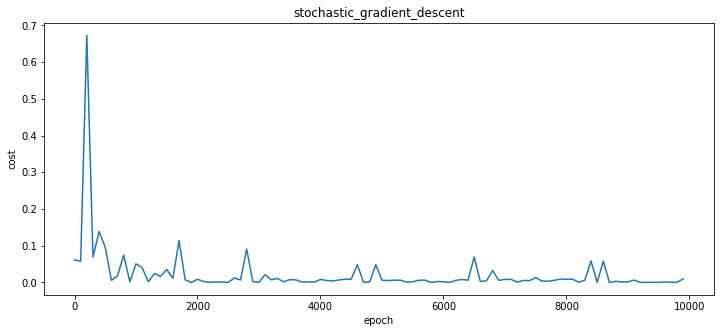

In [ ]:
plt.figure(figsize=(12, 5))
plt.title("stochastic_gradient_descent")
plt.xlabel("epoch")
plt.ylabel("cost")
plt.plot(epoch_list_sgd,cost_list_sgd)

In [ ]:
def mini_batch_gradient_descent(X, y_true, epochs = 100, batch_size = 5, learning_rate = 0.01):
    
    number_of_features = X.shape[1]
    # numpy array with 1 row and columns equal to number of features. In 
    # our case number_of_features = 3 (area, bedroom and age)
    w = np.ones(shape=(number_of_features)) 
    b = 0
    total_samples = X.shape[0] # number of rows in X
    
    if batch_size > total_samples: # In this case mini batch becomes same as batch gradient descent
        batch_size = total_samples
        
    cost_list = []
    epoch_list = []
    
    num_batches = int(total_samples/batch_size)
    
    for i in range(epochs):    
        random_indices = np.random.permutation(total_samples)
        X_tmp = X[random_indices]
        y_tmp = y_true[random_indices]
        
        for j in range(0,total_samples,batch_size):
            Xj = X_tmp[j:j+batch_size]
            yj = y_tmp[j:j+batch_size]
            y_predicted = np.dot(w, Xj.T) + b
            
            w_grad = -(2/len(Xj))*(Xj.T.dot(yj-y_predicted))
            b_grad = -(2/len(Xj))*np.sum(yj-y_predicted)
            
            w = w - learning_rate * w_grad
            b = b - learning_rate * b_grad
                
            cost = np.mean(np.square(yj-y_predicted)) # MSE (Mean Squared Error)
        
        if i%10==0:
            cost_list.append(cost)
            epoch_list.append(i)
        
    return w, b, cost, cost_list, epoch_list

w, b, cost, cost_list, epoch_list = mini_batch_gradient_descent(
    scaled_X,
    scaled_y.reshape(scaled_y.shape[0],),
    epochs = 120,
    batch_size = 5
)
w, b, cost

(array([0.71002199, 0.6781396 ]), -0.23338768097693924, 0.01934377314447882)

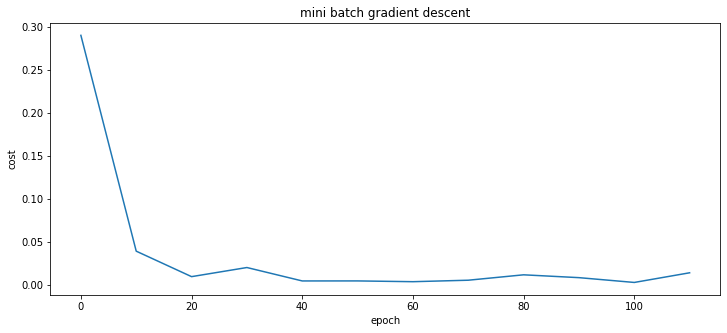

In [ ]:
plt.figure(figsize=(12, 5))
plt.title("mini batch gradient descent")
plt.xlabel("epoch")
plt.ylabel("cost")
plt.plot(epoch_list,cost_list)

In [ ]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

# Creation of the main perceptron object.
class Perceptron(object):
    #Initiating the learning rate and number of iterations.
    def __init__(self, Learn_Rate=0.5, Iterations=10):
        self.learn_rate = Learn_Rate
        self.Iterations = Iterations
        self.errors = []
        self.weights = np.zeros(1 + x.shape[1])
    
    # Defining fit method for model training.
    def fit(self, x, y):
        self.weights = np.zeros(1 + x.shape[1])
        for i in range(self.Iterations):
            error = 0
            for xi, target in zip(x, y):
                update = self.learn_rate * (target - self.predict(xi))
                self.weights[1:] += update*xi
                self.weights[0] += update
                error += int(update != 0)
            self.errors.append(error)
        return self
    
    # Net Input method for summing the given matrix inputs and their corresponding weights.
    def net_input(self, x):
        return np.dot(x, self.weights[1:]) + self.weights[0]
    
    # Predict method for predicting the classification of data inputs.
    def predict(self, x):
        return np.where(self.net_input(x) >= 0.0, 1, -1)

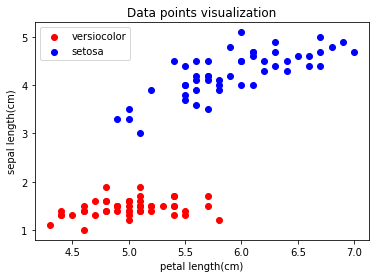

In [ ]:

y = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data", header=None)
x = y.iloc[0:100, [0, 2]].values
plt.scatter(x[:50, 0], x[:50, 1], color='red',label = "versiocolor")
plt.scatter(x[50:100, 0], x[50:100, 1], color='blue',label = "setosa")
plt.scatter(x[100:150, 0], x[100:150, 1], color='yellow')
plt.xlabel('petal length(cm)')
plt.ylabel('sepal length(cm)')
plt.legend(loc='upper left')
plt.title("Results")
plt.title("Data points visualization")
plt.show()
y = y.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

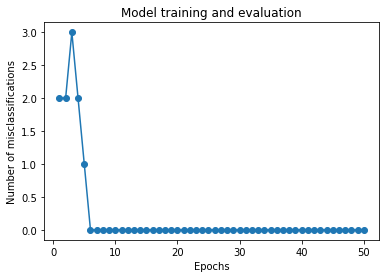

In [ ]:
# Model training and evaluation.
Classifier = Perceptron(Learn_Rate=0.01, Iterations=50)
Classifier.fit(x, y)
plt.plot(range(1, len(Classifier.errors) + 1), Classifier.errors, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Number of misclassifications')
plt.title("Model training and evaluation")
plt.show()


In [ ]:
 from matplotlib.axes._axes import _log as matplotlib_axes_logger
 matplotlib_axes_logger.setLevel('ERROR')

-1 = versicolor
1 = setosa


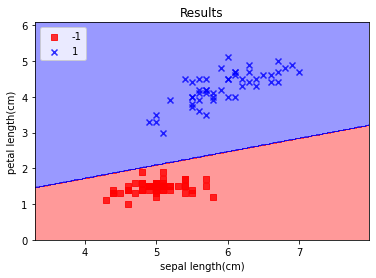

In [ ]:
# Showing the final results of the perceptron model.
print("-1 = versicolor")
print("1 = setosa")
plot_decision_regions(x, y, classifier=Classifier)
plt.xlabel("sepal length(cm)")
plt.ylabel("petal length(cm)")
plt.legend(loc='upper left')
plt.title("Results")

plt.show()

Mean Squared Error: 9.762853674412973



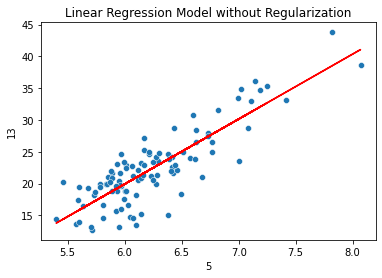

In [ ]:
import warnings
warnings.filterwarnings("ignore")
 
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
 
# Loading data
URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv"
 
# reading data into pandas dataframe
df = pd.read_csv(URL, header=None)
 
# selecting a single feature 
# only using 100 instances for simplicity
X = df.loc[:100, 5]
y = df.loc[:100, 13] # target label 
 
# reshaping the data 
X_reshaped = X[:, np.newaxis]
y_reshaped = y[:, np.newaxis]
 
# instantiating the linear regression model
linear_regression = LinearRegression()
 
# training the model 
linear_regression.fit(X_reshaped, y_reshaped)
 
# making predictions on the training data
y_pred = linear_regression.predict(X_reshaped)
 
# evaluating the model performance
mse = mean_squared_error(y_reshaped, y_pred)
print(f"Mean Squared Error: {mse}\n")
 
# plotting the line of best fit given by linear regression
sns.scatterplot(X,y)
plt.plot(X_reshaped, y_pred, color="red")
plt.title("Linear Regression Model without Regularization")
plt.show() 



Mean Squared Error: 34.709124595627884
Model Coefficients: [0.]



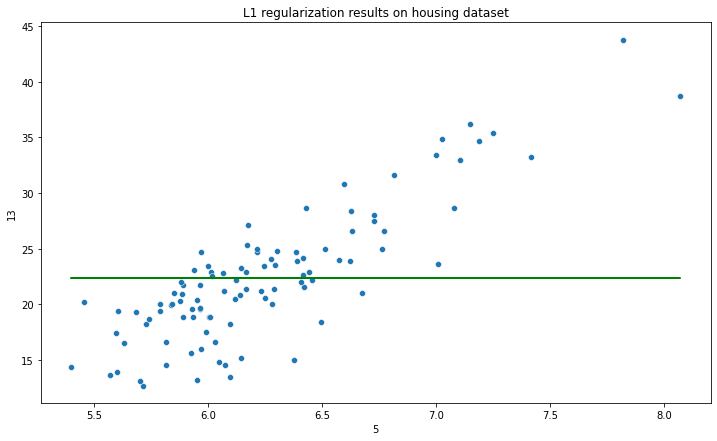

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv"
df = pd.read_csv(URL, header=None) 
X = df.loc[:100, 5]
y = df.loc[:100, 13] 
X_reshaped = X[:, np.newaxis]
y_reshaped = y[:, np.newaxis]
lasso = Lasso(alpha=10)
lasso.fit(X_reshaped, y_reshaped)
y_pred = lasso.predict(X_reshaped)
mse = mean_squared_error(y_reshaped, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Model Coefficients: {lasso.coef_}\n")
plt.figure(figsize=(12, 7))
sns.scatterplot(X,y)
plt.plot(X_reshaped, y_pred, color="green")
plt.title("L1 regularization results on housing dataset")
plt.show() 


Mean Squared Error: 25.96309109305436
Model Coefficients: [[1.98542524]]



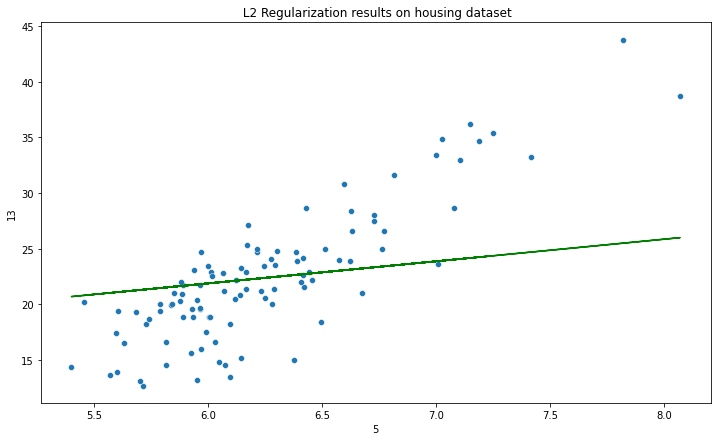

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
URL = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv"
df = pd.read_csv(URL, header=None)
X = df.loc[:100, 5]
y = df.loc[:100, 13]  
X_reshaped = X[:, np.newaxis]
y_reshaped = y[:, np.newaxis]
ridge = Ridge(alpha=100)
ridge.fit(X_reshaped, y_reshaped)
y_pred = ridge.predict(X_reshaped)
mse = mean_squared_error(y_reshaped, y_pred)
plt.figure(figsize=(12, 7))
print(f"Mean Squared Error: {mse}")
print(f"Model Coefficients: {ridge.coef_}\n")
sns.scatterplot(X,y)
plt.plot(X_reshaped, y_pred, color="green")
plt.title(" L2 Regularization results on housing dataset")
plt.show() 

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=60,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip= True,
        fill_mode='nearest')

img = load_img('/content/drive/MyDrive/Colab Notebooks/DL_assignment/m1.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='/content/drive/MyDrive/Colab Notebooks/DL_assignment', save_prefix='mb', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [ ]:

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib  import pyplot as plt

Image augmenatation by brightness change


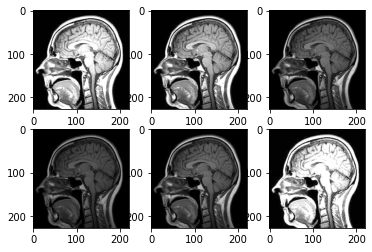

In [ ]:

img = load_img('/content/drive/MyDrive/Colab Notebooks/DL_assignment/m1.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
datagen = ImageDataGenerator(brightness_range=[0.5,2.5])
it = datagen.flow(x, batch_size=1,save_to_dir='/content/drive/MyDrive/Colab Notebooks/DL_assignment', save_prefix='brightness', save_format='jpeg')
print("Image augmenatation by brightness change")
for i in range(6):
	plt.subplot(230 + 1 + i)
	batch = it.next()
	image = batch[0].astype('uint8')
	plt.imshow(image)
plt.show()


Image augmenatation by rotation


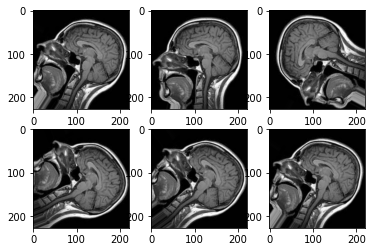

In [ ]:
img = load_img('/content/drive/MyDrive/Colab Notebooks/DL_assignment/m1.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
datagen = ImageDataGenerator(rotation_range=70)
it = datagen.flow(x, batch_size=1,save_to_dir='/content/drive/MyDrive/Colab Notebooks/DL_assignment', save_prefix='rotation', save_format='jpeg')
print("Image augmenatation by rotation")
for i in range(6):
	plt.subplot(230 + 1 + i)
	batch = it.next()
	image = batch[0].astype('uint8')
	plt.imshow(image)
plt.show()

Image augmenatation by shearing image


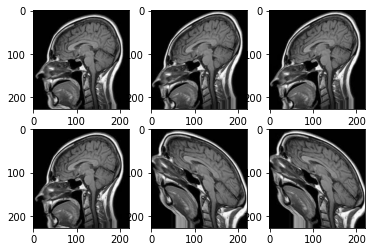

In [ ]:
img = load_img('/content/drive/MyDrive/Colab Notebooks/DL_assignment/m1.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
datagen = ImageDataGenerator(shear_range= 45)
it = datagen.flow(x, batch_size=1,save_to_dir='/content/drive/MyDrive/Colab Notebooks/DL_assignment', save_prefix='shearing', save_format='jpeg')
print("Image augmenatation by shearing image")
for i in range(6):
	plt.subplot(230 + 1 + i)
	batch = it.next()
	image = batch[0].astype('uint8')
	plt.imshow(image)
plt.show()

Image augmenatation by zooming image


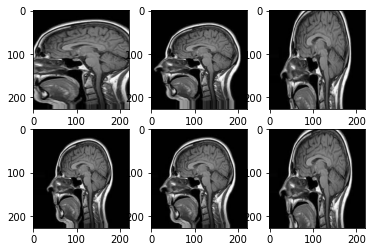

In [ ]:
img = load_img('/content/drive/MyDrive/Colab Notebooks/DL_assignment/m1.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
datagen = ImageDataGenerator(zoom_range=0.35)
it = datagen.flow(x, batch_size=1,save_to_dir='/content/drive/MyDrive/Colab Notebooks/DL_assignment', save_prefix='zooming', save_format='jpeg')
print("Image augmenatation by zooming image")
for i in range(6):
	plt.subplot(230 + 1 + i)
	batch = it.next()
	image = batch[0].astype('uint8')
	plt.imshow(image)
plt.show()

Image augmenatation by flipping image


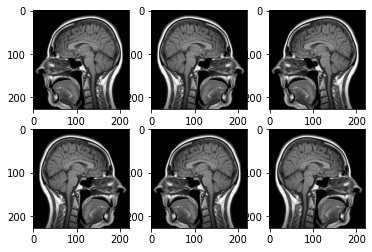

In [ ]:
img = load_img('/content/drive/MyDrive/Colab Notebooks/DL_assignment/m1.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)
datagen = ImageDataGenerator(horizontal_flip=True)
it = datagen.flow(x, batch_size=1,save_to_dir='/content/drive/MyDrive/Colab Notebooks/DL_assignment', save_prefix='flip', save_format='jpeg')
print("Image augmenatation by flipping image")
for i in range(6):
	plt.subplot(230 + 1 + i)
	batch = it.next()
	image = batch[0].astype('uint8')
	plt.imshow(image)
plt.show()